In [ ]:
# import numpy as np
def roc(y_true, y_score, pos_label):
    """
    y_true：真实标签
    y_score：模型预测分数
    pos_label：正样本标签，如“1”
    """
    # 统计正样本和负样本的个数
    num_positive_examples = (y_true == pos_label).sum()
    num_negtive_examples = len(y_true) - num_positive_examples

    tp, fp = 0, 0
    tpr, fpr, thresholds = [], [], []
    score = max(y_score) + 1
    
    # 根据排序后的预测分数分别计算fpr和tpr
    for i in np.flip(np.argsort(y_score)):
        # 处理样本预测分数相同的情况
        if y_score[i] != score:
            fpr.append(fp / num_negtive_examples)
            tpr.append(tp / num_positive_examples)
            thresholds.append(score)
            score = y_score[i]
            
        if y_true[i] == pos_label:
            tp += 1
        else:
            fp += 1

    fpr.append(fp / num_negtive_examples)
    tpr.append(tp / num_positive_examples)
    thresholds.append(score)

    return fpr, tpr, thresholds



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
y_true = np.array(
    [1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]
)
y_score = np.array([
    .9, .8, .7, .6, .55, .54, .53, .52, .51, .505,
    .4, .39, .38, .37, .36, .35, .34, .33, .3, .1
])

fpr, tpr, thresholds = roc(y_true, y_score, pos_label=1)


plt.plot(fpr, tpr)
plt.axis("square")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()


### 正常训练

In [ ]:
from sklearn.metrics import roc_auc_score
# 导入必要的库
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
import scipy.io as sio  # 从.mat文件中读取数据集
import numpy as np

################################################################加载数据集################################################
# 数据集
mat_data = sio.loadmat('../data/dataset/Connect4.mat')
# 提取变量
dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.3, random_state=42)

# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 构建并训练MLP模型
mlp = MLPClassifier(hidden_layer_sizes=(10, 20), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# 预测和评估模型
y_pred = mlp.predict(X_test)
print(y_pred)

# 输出结果
print("准确率:", accuracy_score(y_test, y_pred))
print("\n分类报告:\n", classification_report(y_test, y_pred))



#roc_auc_score()

### Gmean、mAUC、PPVs

(1000, 10)


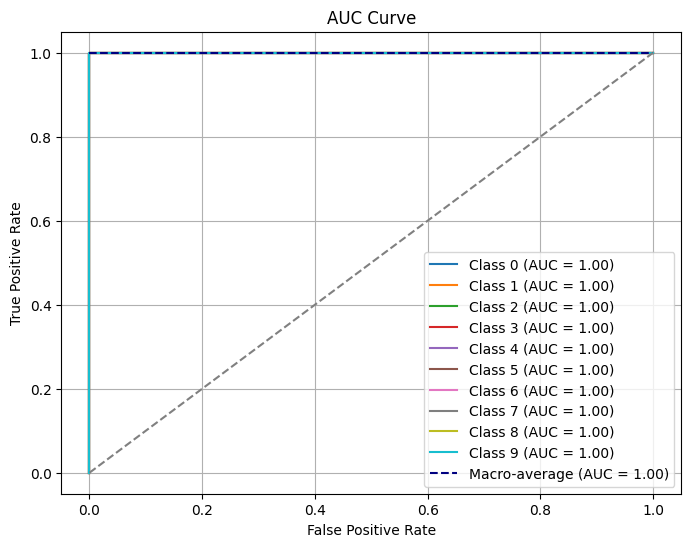

1.0
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
1.0
1.0
1.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
from scipy.stats import gmean
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score,accuracy_score
import numpy as np
import matplotlib.pyplot as plt

################################################################加载数据集################################################
# 数据集
mat_data = sio.loadmat('../data/dataset/LedDisplay.mat')
# 提取变量
dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]

# One-hot encode target variable
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(dataset_y.reshape(-1, 1))
print(y_onehot.shape)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_x, y_onehot, test_size=0.3, random_state=42, stratify=dataset_y)

# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Multi-Layer Perceptron (MLP) model
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=800, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Predict probabilities for the test set
# 计算m-AUC
y_pred_proba = mlp.predict_proba(X_test_scaled)


# 计算accuracy
y_pred = mlp.predict(X_test_scaled)
# Convert one-hot encoded test labels back to single class labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)


# 计算每个类别的 Precision
class_precisions = precision_score(y_test_labels, y_pred_labels, average=None)


class_accuracies = {}
for class_label in np.unique(y_test_labels):
    indices = (y_test_labels == class_label)
    
    class_accuracies[class_label] = accuracy_score(y_test_labels[indices], y_pred_labels[indices])
# Compute AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_onehot.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#print(y_pred_proba.shape)
#print("预测的概率：",y_pred_proba)
# Compute macro AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_onehot.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_onehot.shape[1]):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= y_onehot.shape[1]
macro_auc = auc(all_fpr, mean_tpr)

# Plot AUC curves
plt.figure(figsize=(8, 6))
for i in range(y_onehot.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(all_fpr, mean_tpr, label=f'Macro-average (AUC = {macro_auc:.2f})', linestyle='--', color='navy')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

macro_auc
class_accuracies
# 计算几何平均准确率
geometric_mean_accuracy_1 = np.prod(list(class_accuracies.values()))**(1 / len(class_accuracies))

geometric_mean_accuracy_2=gmean(list(class_accuracies.values()))
geometric_mean_accuracy_3=gmean(class_precisions)

print(macro_auc)
print(class_accuracies)
print(geometric_mean_accuracy_1)
print(geometric_mean_accuracy_2)
print(geometric_mean_accuracy_3)
print(class_precisions)

### 去除One-hot encode

In [12]:
from scipy.stats import gmean
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score,accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from utils.dataset_utils import get_classes_indexes_counts

################################################################加载数据集################################################
# 数据集
mat_data = sio.loadmat('../data/dataset/Vehicle.mat')
# 提取变量
dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
# 显示数据集分布
print("特征数据:", dataset_x.shape)
print("label:", dataset_y.shape)
# 统计每个类别的个数，dataset_y.max()+1是类别的个数
classes, counts = get_classes_indexes_counts(dataset_y)
print(len(classes))
print("每种类别的数量：", counts)
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.3, random_state=42, stratify=dataset_y)

# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Multi-Layer Perceptron (MLP) model
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=800, random_state=42)
mlp.fit(X_train_scaled, y_train)

# Predict probabilities for the test set

# 用来计算m-AUC
y_pred_proba = mlp.predict_proba(X_test_scaled)

# 用来计算accuracy
y_pred = mlp.predict(X_test_scaled)

# Convert one-hot encoded test labels back to single class labels
#y_test_labels = np.argmax(y_test, axis=1)
#y_pred_labels = np.argmax(y_pred, axis=1)


# 计算每个类别的 Precision
class_precisions = precision_score(y_test, y_pred, average=None)


class_accuracies = {}
for class_label in np.unique(y_test):
    indices = (y_test == class_label)
    
    class_accuracies[class_label] = accuracy_score(y_test[indices], y_pred[indices])
# Compute AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
# len(classes)表示类的数量
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#print(y_pred_proba.shape)
#print("预测的概率：",y_pred_proba)
# Compute macro AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
macro_auc = auc(all_fpr, mean_tpr)

# Plot AUC curves
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(all_fpr, mean_tpr, label=f'Macro-average (AUC = {macro_auc:.2f})', linestyle='--', color='navy')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

macro_auc
class_accuracies
# 计算几何平均准确率
geometric_mean_accuracy_1 = np.prod(list(class_accuracies.values()))**(1 / len(class_accuracies))

geometric_mean_accuracy_2=gmean(list(class_accuracies.values()))

print(macro_auc)
print(class_accuracies)
print(geometric_mean_accuracy_1)
print(geometric_mean_accuracy_2)
print(class_precisions)

特征数据: (846, 18)
label: (846,)
4
每种类别的数量： [218 212 217 199]


D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed